In [29]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import gget
import sys
from collections import Counter
import scipy
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
import umap

import scanpy as sc
import scanpy.external as sce
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sc.settings.verbosity = 3

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 8562 × 14972
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Silhouette Coefficient 
The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [3]:
res = []

metric = 'euclidean'
evaluation_space = 'X_umap'

cdf = adata.uns['clusters']
X = adata.obsm[evaluation_space]
print(f"{X.shape=}")

for cluster in cdf.columns:
    cluster_labels = cdf[cluster].values
    
    n_clusters = len(np.unique(cluster_labels)) 
    
    if n_clusters < 2:
        ss = 0
    else:
        ss = silhouette_score(X, cluster_labels, metric=metric)
        
    row = {
        'resolution' : float(cluster.replace("r", "")) / 100,
        'n_clusters' : n_clusters,
        'silhouette_score' : ss
    }
    res.append(row)
    
res = pd.DataFrame(res)
res.groupby('n_clusters')['resolution'].min()

X.shape=(8562, 2)


n_clusters
1     0.00
2     0.01
3     0.05
4     0.10
5     0.13
6     0.22
7     0.41
8     0.45
9     0.59
10    0.62
11    0.75
Name: resolution, dtype: float64

Text(0.5, 1.0, 'Silhouette Scores (Euclidean, UMAP)')

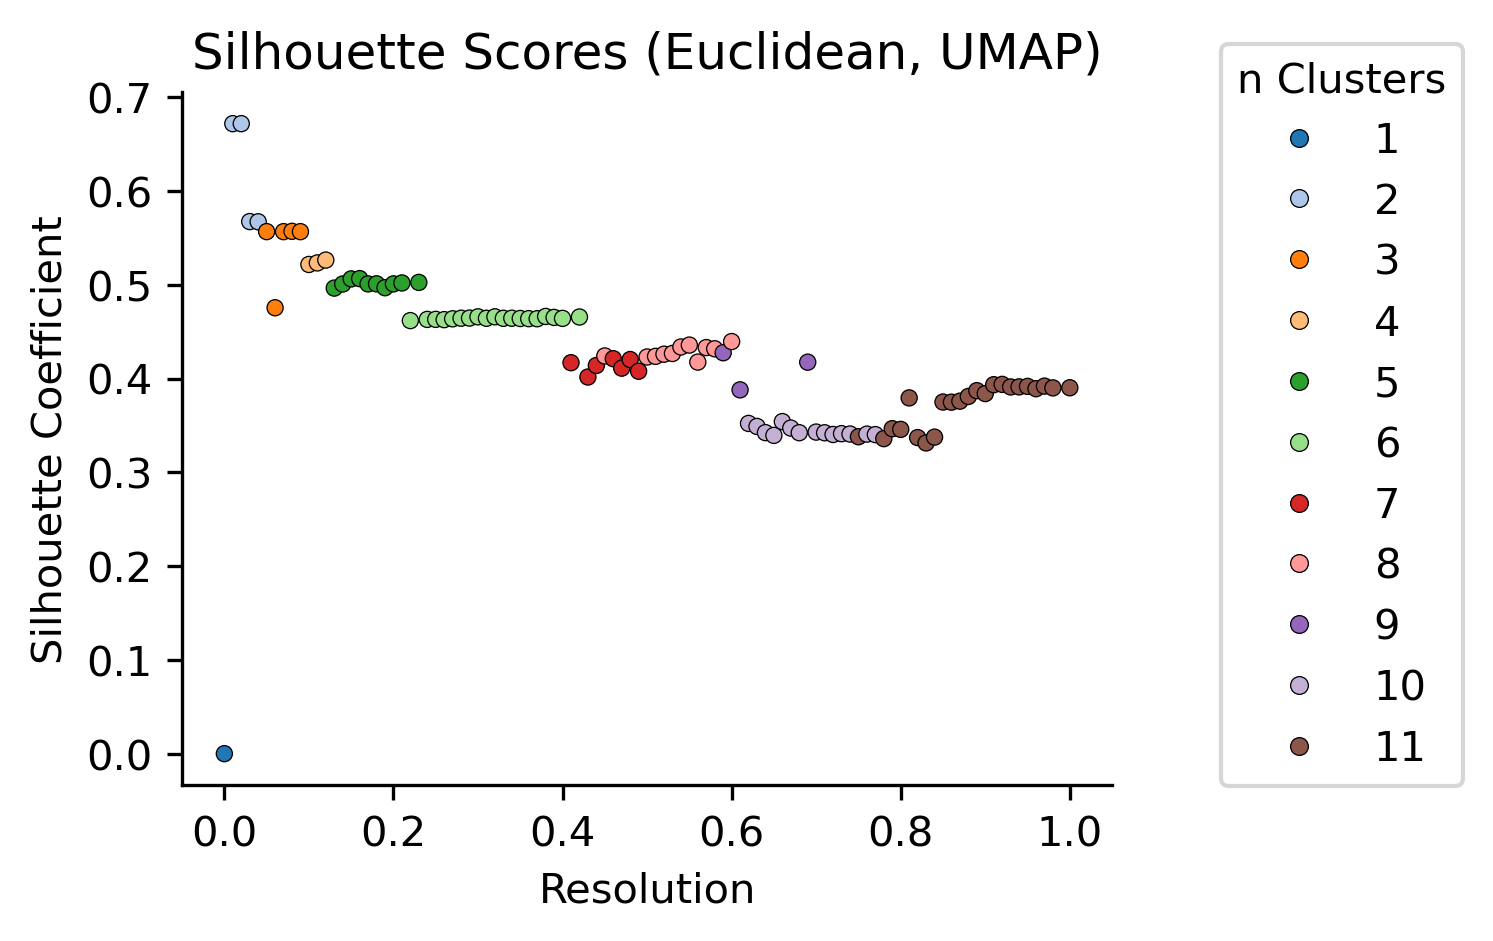

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.scatterplot(data=res, 
                x='resolution',
                y='silhouette_score',
                ec='k',
                s=15,
                hue='n_clusters',
                palette='tab20',
               )

plt.ylabel("Silhouette Coefficient")
plt.xlabel("Resolution")

sns.move_legend(plt.gca(), 
                title="n Clusters",
                loc='upper right',
                markerscale=1.1,
                bbox_to_anchor=(1.4, 1.1))

sns.despine()
plt.title("Silhouette Scores (Euclidean, UMAP)")

In [5]:
res = []

metric = 'euclidean'
evaluation_space = 'X_pca'

cdf = adata.uns['clusters']
X = adata.obsm[evaluation_space]
print(f"{X.shape=}")

for cluster in cdf.columns:
    cluster_labels = cdf[cluster].values
    
    n_clusters = len(np.unique(cluster_labels)) 
    
    if n_clusters < 2:
        ss = 0
    else:
        ss = silhouette_score(X, cluster_labels, metric=metric)
        
    row = {
        'resolution' : float(cluster.replace("r", "")) / 100,
        'n_clusters' : n_clusters,
        'silhouette_score' : ss
    }
    res.append(row)
    
res = pd.DataFrame(res)
res.groupby('n_clusters')['resolution'].min()

X.shape=(8562, 50)


n_clusters
1     0.00
2     0.01
3     0.05
4     0.10
5     0.13
6     0.22
7     0.41
8     0.45
9     0.59
10    0.62
11    0.75
Name: resolution, dtype: float64

Text(0.5, 1.0, 'Silhouette Scores (Euclidean, PCA)')

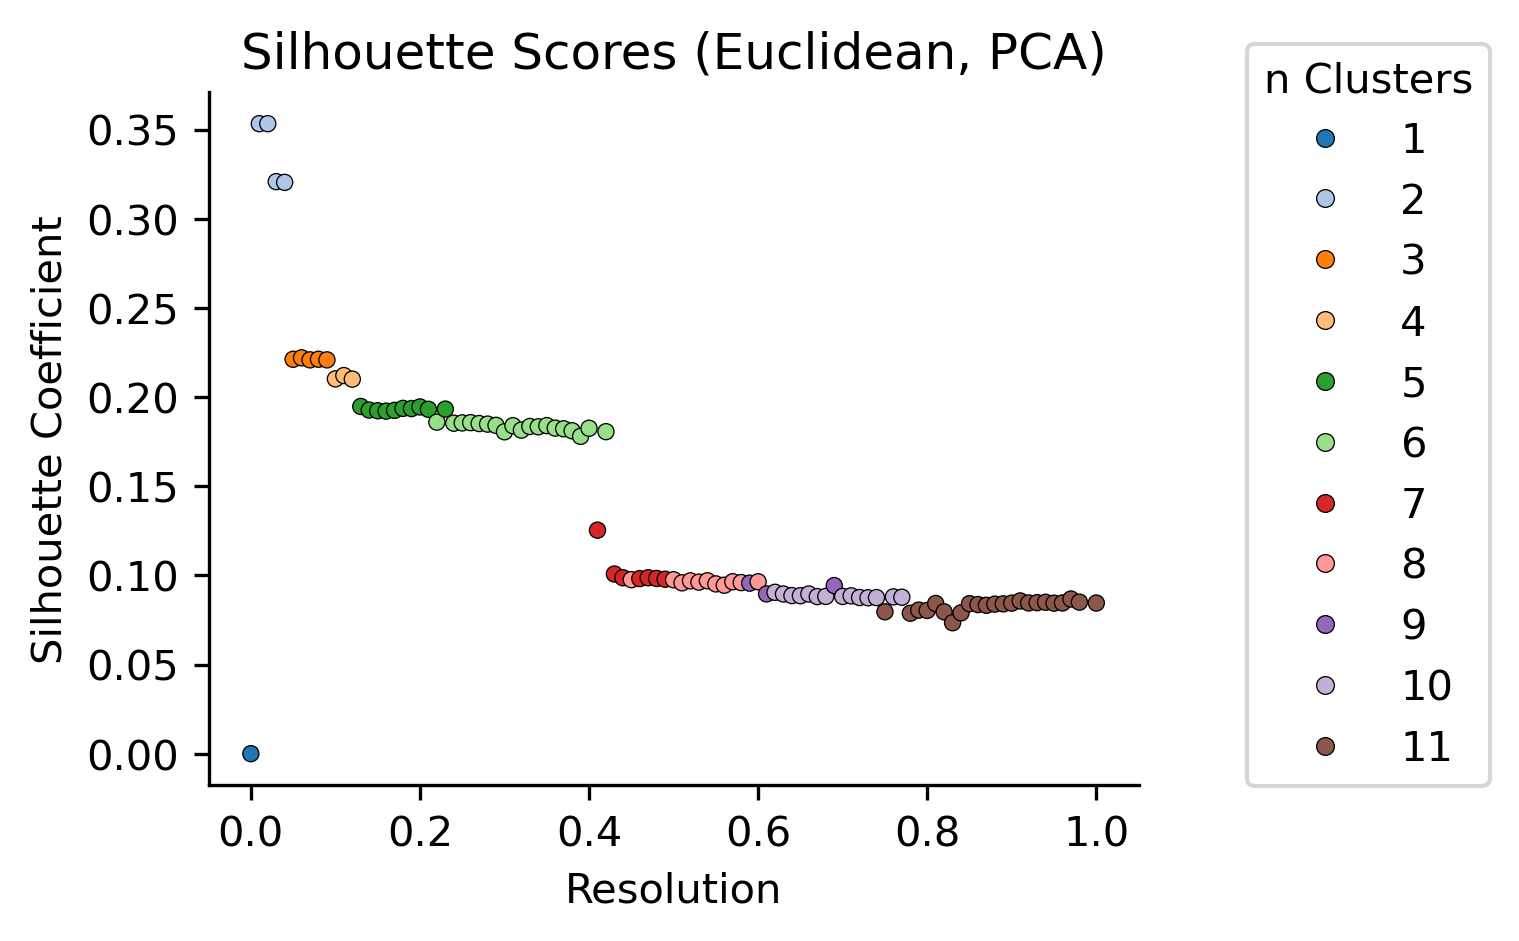

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.scatterplot(data=res, 
                x='resolution',
                y='silhouette_score',
                ec='k',
                s=15,
                hue='n_clusters',
                palette='tab20',
               )

plt.ylabel("Silhouette Coefficient")
plt.xlabel("Resolution")

sns.move_legend(plt.gca(), 
                title="n Clusters",
                loc='upper right',
                markerscale=1.1,
                bbox_to_anchor=(1.4, 1.1))

sns.despine()
plt.title("Silhouette Scores (Euclidean, PCA)")

# PCA Metrics

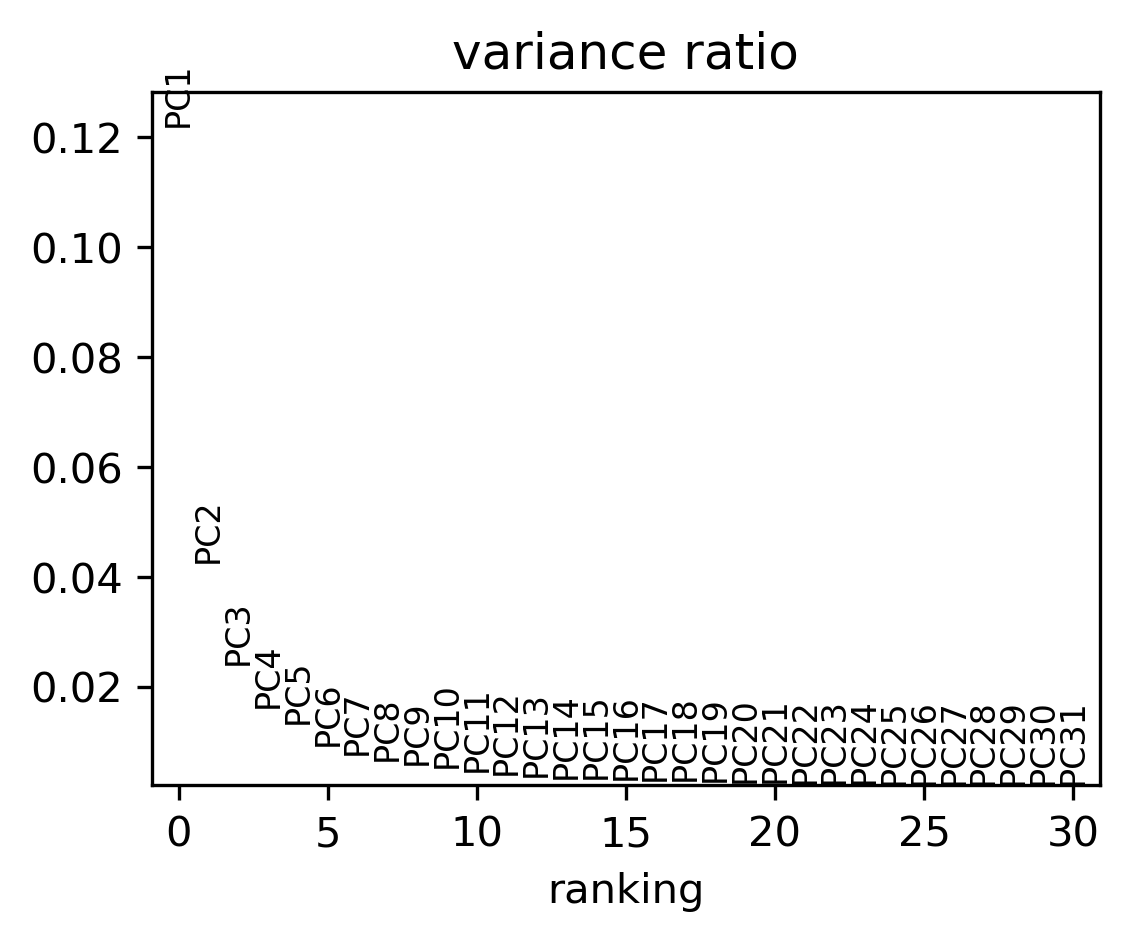

In [13]:
sc.pl.pca_variance_ratio(adata)

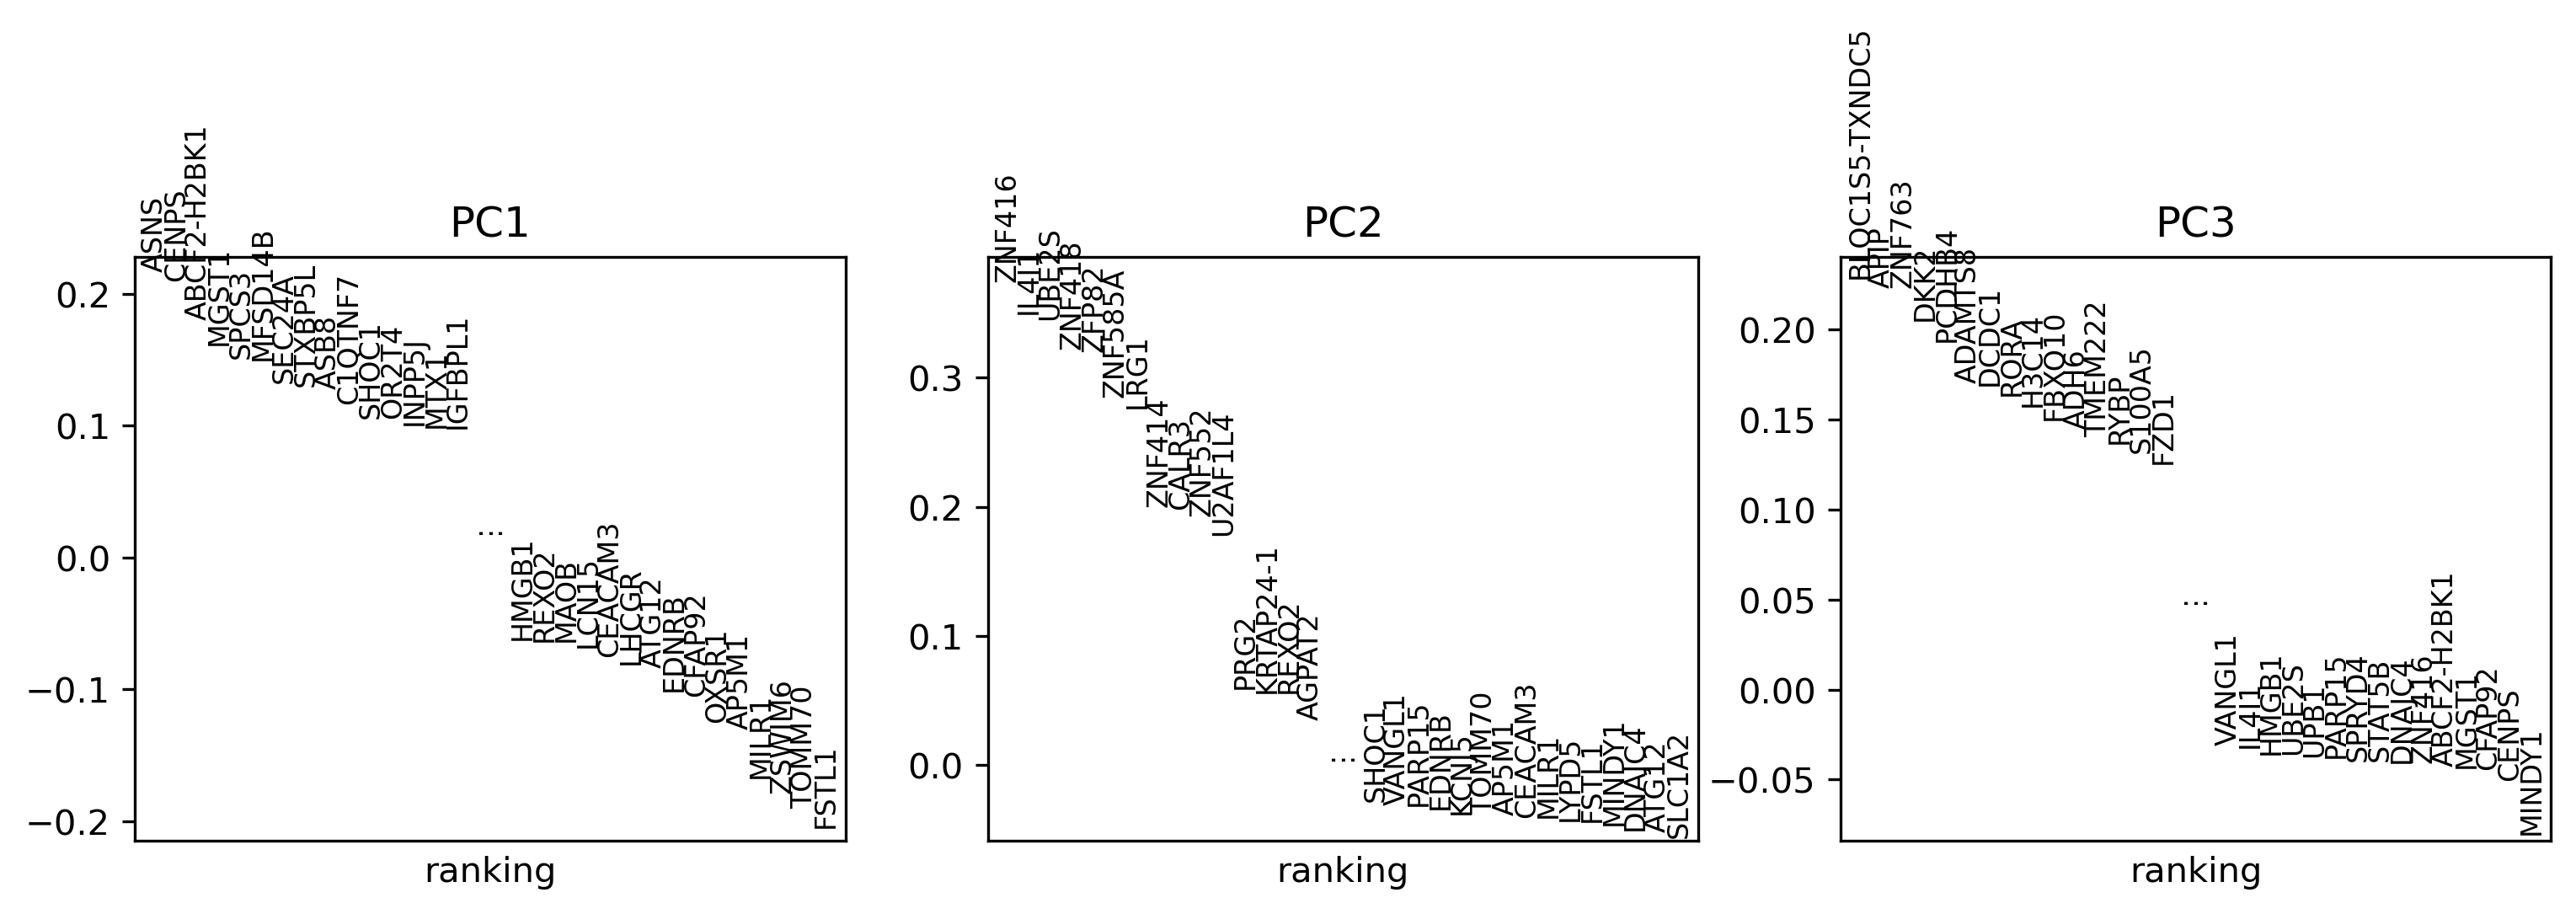

In [15]:
adata.var_names = adata.var['gene_name'].values
sc.pl.pca_loadings(adata)

In [28]:
loadings = pd.DataFrame(adata.varm['PCs'], index=adata.var_names)
loadings.columns = [f"PC{x+1}" for x in loadings.columns]
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
ASNS,0.216752,0.020594,-0.025278,-0.003634,-0.033337,-0.050652,-0.020660,0.020458,0.013594,-0.049356,...,-0.062550,0.025103,0.050862,0.055288,0.029296,0.052167,-0.052303,-0.014290,0.115532,0.027928
CENPS,0.210129,0.012706,-0.050447,-0.056723,-0.058190,-0.087711,0.065852,0.015021,0.037186,-0.012446,...,-0.002636,0.013892,0.015935,0.035398,0.015058,0.012295,-0.005612,0.026760,0.027554,0.018092
ABCF2-H2BK1,0.180281,0.007875,-0.042316,-0.078664,-0.096726,-0.072721,0.025768,-0.021430,-0.040111,0.019264,...,-0.017147,0.020491,0.010503,0.031303,0.004778,0.018354,-0.007278,0.034221,0.036520,0.025674
MGST1,0.161546,0.018506,-0.043344,-0.077411,-0.120219,-0.054492,-0.006099,-0.072344,-0.103660,-0.013830,...,0.004578,0.005031,0.017390,-0.006951,0.014833,0.058357,-0.018900,0.000233,0.010669,0.020759
SPCS3,0.150986,0.006133,-0.026638,-0.048795,-0.091068,-0.075783,-0.106335,-0.070199,-0.231960,-0.162778,...,-0.019099,0.115692,-0.031822,0.088587,0.048553,0.003333,-0.033760,-0.063209,0.046676,-0.055946


# TRANSFAC

In [51]:
n_genes = 10
n_print = 10
sort_by = 'PC1'
database = 'TRANSFAC_and_JASPAR_PWMs'
alpha = 0.01

loadings = loadings.sort_values(by=sort_by, ascending=False)
genes = loadings.head(n_genes).index

edf = gget.enrichr(genes, database=database)

for idx, row in edf.head(n_print).iterrows():
    print(f"{row['path_name']} (p={row['adj_p_val']:.4f}) --> {row['overlapping_genes']}")

Wed May 22 10:45:55 2024 INFO Performing Enichr analysis using database TRANSFAC_and_JASPAR_PWMs.


HMGA1 (human) (p=0.7478) --> ['C1QTNF7', 'MGST1', 'STXBP5L']
RUNX2 (human) (p=0.7478) --> ['C1QTNF7', 'ASB8', 'MGST1']
STAT1 (human) (p=0.7478) --> ['MGST1', 'ASNS', 'STXBP5L']
ETV4 (mouse) (p=0.7478) --> ['C1QTNF7', 'MGST1', 'STXBP5L']
CEBPE (human) (p=0.7478) --> ['ASNS']
RORB (mouse) (p=0.7478) --> ['C1QTNF7', 'ASNS']
NR2F1 (mouse) (p=0.7478) --> ['C1QTNF7', 'ASNS']
FOXD1 (human) (p=0.7478) --> ['MGST1']
CRTC1 (human) (p=0.7478) --> ['C1QTNF7', 'STXBP5L']
NKX2-8 (human) (p=0.7478) --> ['STXBP5L']


In [52]:
n_genes = 10
n_print = 10
sort_by = 'PC2'
database = 'TRANSFAC_and_JASPAR_PWMs'
alpha = 0.01

loadings = loadings.sort_values(by=sort_by, ascending=False)
genes = loadings.head(n_genes).index

edf = gget.enrichr(genes, database=database)

for idx, row in edf.head(n_print).iterrows():
    print(f"{row['path_name']} (p={row['adj_p_val']:.4f}) --> {row['overlapping_genes']}")

Wed May 22 10:46:00 2024 INFO Performing Enichr analysis using database TRANSFAC_and_JASPAR_PWMs.


IKZF1 (human) (p=0.3940) --> ['IL4I1', 'CALR3', 'ZNF414']
FOXF2 (human) (p=0.3940) --> ['IL4I1', 'CALR3', 'ZNF414']
GATA3 (human) (p=0.3940) --> ['ZNF418', 'ZNF416', 'ZNF552', 'ZNF585A']
AHR (human) (p=0.3940) --> ['IL4I1', 'ZNF416', 'ZNF414']
NFYA (human) (p=0.3940) --> ['CALR3', 'LRG1', 'UBE2S', 'ZNF585A']
RXRA (human) (p=0.3940) --> ['LRG1', 'ZNF418', 'ZNF414']
SREBF1 (human) (p=0.3940) --> ['IL4I1', 'UBE2S', 'ZNF416', 'ZFP82']
CBEPB (human) (p=0.3940) --> ['ZNF416', 'ZFP82', 'ZNF552', 'ZNF585A']
FOXJ1 (human) (p=0.3940) --> ['IL4I1', 'ZNF418', 'ZNF414']
JDP2 (human) (p=0.3940) --> ['LRG1', 'ZFP82', 'ZNF585A']


In [58]:
n_genes = 50
n_print = 10
sort_by = 'PC1'
database = 'GO_Biological_Process_2023'
alpha = 0.01

loadings = loadings.sort_values(by=sort_by, ascending=False)
genes = loadings.head(n_genes).index

edf = gget.enrichr(genes, database=database)

for idx, row in edf.head(n_print).iterrows():
    print(f"{row['path_name']} (p={row['adj_p_val']:.4f}) --> {row['overlapping_genes']}")

Wed May 22 10:48:32 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2023.


Protein Processing (GO:0016485) (p=0.0309) --> ['SPCS3', 'FAM111A', 'TLL2', 'TLL1']
Peptidyl-Lysine Dimethylation (GO:0018027) (p=0.0309) --> ['SETD2', 'EHMT2']
Resolution Of Meiotic Recombination Intermediates (GO:0000712) (p=0.0516) --> ['SHOC1', 'CENPS']
Mismatch Repair (GO:0006298) (p=0.0974) --> ['SETD2', 'PMS2']
Peptidyl-Lysine Methylation (GO:0018022) (p=0.0974) --> ['SETD2', 'EHMT2']
Dorsal/Ventral Pattern Formation (GO:0009953) (p=0.0974) --> ['TLL2', 'TLL1']
Collagen Fibril Organization (GO:0030199) (p=0.1692) --> ['TLL2', 'TLL1']
DNA-templated DNA Replication Maintenance Of Fidelity (GO:0045005) (p=0.1692) --> ['FAM111A', 'CENPS']
Replication Fork Processing (GO:0031297) (p=0.1692) --> ['FAM111A', 'CENPS']
DNA Repair (GO:0006281) (p=0.1692) --> ['FAM111A', 'SETD2', 'PMS2', 'CENPS']


In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)